##  Imports and Setup

In [1]:
# Import external parse_circuit function
from parse_circuit import parse_circuit

In [2]:
import os
import warnings
from os import path

# Suppress warnings for cleaner outputs
warnings.filterwarnings("ignore")

# Path to data directory
DATA_PATH = "./grape"

# Set the working directory
os.chdir(DATA_PATH)

import grape  # Grammatical evolution library

# Path to grammar file
GRAMMAR_FILE = "grover.bnf"
BNF_GRAMMAR_PATH = path.join("grammars", GRAMMAR_FILE)
BNF_GRAMMAR = grape.Grammar(BNF_GRAMMAR_PATH)
import algorithms  # Evolutionary algorithms


In [3]:
from qiskit import QuantumCircuit, transpile  # Core Qiskit imports
from qiskit_aer import QasmSimulator  # Simulator
from qiskit.visualization import plot_histogram  # Plotting results
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from deap import creator, base, tools  # Genetic Algorithm tools

## Define Oracle and Reflection Operators

In [4]:
# Define the oracle dynamically for the marked state
def create_oracle(marked_state):
    n = len(marked_state)
    oracle = QuantumCircuit(n, name='oracle')
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(i)
    oracle.h(n - 1)
    oracle.mcx(list(range(n - 1)), n - 1)
    oracle.h(n - 1)
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(i)
    return oracle.to_gate()

In [5]:
# Define the Grover reflection operator
def create_reflection(n):
    reflection = QuantumCircuit(n, name='reflection')
    reflection.h(range(n))
    reflection.x(range(n))
    reflection.h(n - 1)
    reflection.mcx(list(range(n - 1)), n - 1)
    reflection.h(n - 1)
    reflection.x(range(n))
    reflection.h(range(n))
    return reflection.to_gate()

In [6]:
# Define the Grover's circuit with a specific marked state
def grover_circuit(marked_state):
    """
    Creates the full Grover circuit for a given marked state.
    """
    n = len(marked_state)  # Number of qubits required
    grover_circ = QuantumCircuit(n, n)  # Classical bits = qubits for measurement
    grover_circ.h(range(n))  # Apply Hadamard gates to all qubits

    # Add the oracle and reflection gates
    oracle_gate = create_oracle(marked_state)
    reflection_gate = create_reflection(n)

    # Repeat Grover iterations
    num_iterations = int(np.round(np.sqrt(2 ** n)))  # Optimal number of iterations
    for _ in range(num_iterations):
        grover_circ.append(oracle_gate, range(n))
        grover_circ.append(reflection_gate, range(n))

    # Measure all qubits
    grover_circ.measure(range(n), range(n))
    return grover_circ

In [ ]:
# Test Grover's circuit with a specific marked state
marked_state = '001'  # Specify the marked state
grover_circ = grover_circuit(marked_state)
grover_circ.draw('mpl')


In [8]:
# Simulate the Grover circuit
simulator = QasmSimulator()
compiled_circuit = transpile(grover_circ, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()

In [ ]:
# Get the measurement counts (bitstring outcomes)
counts = result.get_counts()
corrected_counts = {k[::-1]: v for k, v in counts.items()}  # Reverse bitstrings
print(corrected_counts)



In [ ]:
# Plot the results
display(plot_histogram(corrected_counts))

# Grammatical Evolution

## Fitness Function

In [11]:
def fitness_function(circuit, marked_state='100', threshold=0.48):
    """
    Calculate the fitness of a quantum circuit for Grover's problem.
    Lower is better. Includes a penalty for circuit length.
    """
    simulator = QasmSimulator()
    compiled_circuit = transpile(circuit, simulator)
    fitness = float('inf')

    try:
        result = simulator.run(compiled_circuit, shots=1024).result()
        counts = result.get_counts()

        # Probability of each measured state
        total_shots = sum(counts.values())
        probabilities = {state: count / total_shots for state, count in counts.items()}

        # "Misses" = sum of large probabilities for states != marked_state
        misses = sum(prob for state, prob in probabilities.items()
                     if state != marked_state and prob > threshold)

        # Max error = highest probability for a non-marked state
        max_error_prob = max(
            (prob for state, prob in probabilities.items() if state != marked_state),
            default=0.0
        )

        # Fitness = 10 * misses + max_error_prob
        fitness = 10 * misses + max_error_prob

        # Calculate penalty for circuit length
        length_penalty = len(circuit) * 0.01  # Adjust the factor as needed
        fitness += length_penalty

    except Exception as e:
        print(f"[Simulation Error] {e}")
        print("[Circuit Debug]")
        print(circuit.draw('text'))

    return fitness

## Decode Individual

In [12]:
import re

def decode_individual(ind):
    """
    Decodes the individual's genome into a quantum circuit.
    Returns:
        A QuantumCircuit object if decoding is successful,
        or None if invalid.
    """
    if ind.invalid or not hasattr(ind, 'phenotype'):
        # print("[Phenotype] Invalid individual: No phenotype available.")
        return None

    try:
        # The phenotype should be a single string; ensure proper handling
        phenotype_code = ind.phenotype

        # If the phenotype is a list, join it into a single string
        if isinstance(phenotype_code, list):
            phenotype_code = "".join(phenotype_code)

        # Use regex to clean the phenotype
        cleaned_code = re.sub(r'\\n', '\n', phenotype_code)  # Replace \n literals with real newlines
        cleaned_code = re.sub(r'^"|"$', '', cleaned_code)  # Remove any leading/trailing double quotes
        cleaned_code = re.sub(r'"\s+"', '\n', cleaned_code)  # Replace isolated quotes with newlines

        # Pass the cleaned code string to parse_circuit
        qc = parse_circuit(cleaned_code)

        return qc

    except Exception as ex:
        print(f"[Decode Error] {ex}")
        # print("[Phenotype Debug] Phenotype was:")
        # print(ind.phenotype)
        return None

##  GE Initialization

In [13]:
POPULATION_SIZE = 100
MAX_GENERATIONS = 5
P_CROSSOVER = 0.7
P_MUTATION = 0.1
ELITE_SIZE = 1
HALLOFFAME_SIZE = 1

In [14]:
# Create fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

# Initialize toolbox
toolbox = base.Toolbox()
# Use GRAPE's sensible initialization to create individuals from the grammar.
toolbox.register(
    "populationCreator",
    grape.sensible_initialisation,
    creator.Individual,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=10,
    max_init_depth=6,
    codon_size=255,
    codon_consumption="lazy",
    genome_representation="list"
)
toolbox.register("mate", grape.crossover_onepoint)
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
toolbox.register("select", tools.selTournament, tournsize=3)


## Evaluate Function

In [15]:
# %%
# Simplified evaluation using decode_individual and fitness_function
def evaluate(ind, marked_state='100', threshold=0.48):
    """
    Decode the individual's phenotype, then evaluate its fitness using the fitness_function.
    Includes debugging information for invalid individuals and penalties.
    """
    # Decode the individual's phenotype
    qc = decode_individual(ind)
    if qc is None:
        return (float('inf'),)  # Treat as neutral fitness

    # Evaluate the fitness of the circuit
    fitness_val = fitness_function(qc, marked_state=marked_state, threshold=threshold)
    return (fitness_val,)
# Register the evaluation function in the DEAP toolbox
toolbox.register("evaluate", evaluate)

[DEBUG] Executing Code:
 qc = QuantumCircuit(3, 3)

qc.h(0)
qc.h(1)
qc.h(2)

qc.mcx([0, 1], 2)

qc.h(1)

qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)

[DEBUG] Executing Code:
 qc = QuantumCircuit(3, 3)

qc.h(0)
qc.h(1)
qc.h(2)

qc.x(2)

qc.ccx(0, 1, 2)

qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)

[DEBUG] Executing Code:
 qc = QuantumCircuit(3, 3)

qc.h(0)
qc.h(1)
qc.h(2)

qc.cx(0, 2)

qc.z(2)

qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)

[DEBUG] Executing Code:
 qc = QuantumCircuit(3, 3)

qc.h(0)
qc.h(1)
qc.h(2)

qc.ccx(0, 1, 2)

qc.ccx(0, 1, 2)

qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)

[DEBUG] Executing Code:
 qc = QuantumCircuit(3, 3)

qc.h(0)
qc.h(1)
qc.h(2)

qc.cx(1, 2)

qc.h(2)

qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)

[DEBUG] Executing Code:
 qc = QuantumCircuit(3, 3)

qc.h(0)
qc.h(1)
qc.h(2)

qc.cx(0, 1)

qc.cz(0, 1)

qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)

[DEBUG] Executing Code:
 qc = QuantumCircuit(3, 3)

qc.h(0)
qc.h(1)


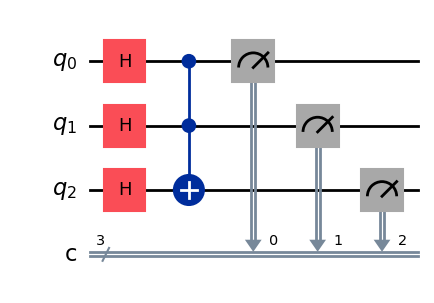

In [16]:
# Create initial population
population = toolbox.populationCreator(pop_size=POPULATION_SIZE)
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# Prepare statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Use a custom GE evolutionary algorithm from "algorithms" (if provided),
# or use deap.algorithms.eaSimple with some modifications.
population, logbook = algorithms.ge_eaSimpleWithElitism(
    population, 
    toolbox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    elite_size=ELITE_SIZE,
    bnf_grammar=BNF_GRAMMAR,
    codon_size=255,
    max_tree_depth=17,
    max_genome_length=None,
    codon_consumption="lazy",
    report_items=["gen", "min", "max", "avg", "std"],
    genome_representation="list",
    stats=stats,
    halloffame=hof,
    verbose=True
)

# Iterate over generations
for gen in range(MAX_GENERATIONS):
    # print(f"\n[GENERATION {gen}]")
    invalid_count = 0  # Count invalid individuals for this generation

    valid_individuals = []  # Track valid individuals
    for ind in population:
        qc = decode_individual(ind)
        if qc is None:
            invalid_count += 1
            # Assign neutral fitness for invalid individuals
            ind.fitness.values = (float('inf'),)  # Neutral value
            # print(f"[DEBUG] Invalid Individual in Generation {gen}:\nGenome: {ind.genome}\nPhenotype: {ind.phenotype}")
        else:
            valid_individuals.append(ind)
            fitness = fitness_function(qc, marked_state='100', threshold=0.48)
            ind.fitness.values = (fitness,)
            # print(f"[DEBUG] Valid Individual in Generation {gen}:\nGenome: {ind.genome}\nPhenotype: {ind.phenotype}\nFitness: {fitness}\n")
    
    # Statistics for valid individuals
    valid_fitnesses = [ind.fitness.values[0] for ind in valid_individuals]
    average_fitness = sum(valid_fitnesses) / len(valid_fitnesses) if valid_fitnesses else float('inf')
    
# Decode and display the best circuit from Hall of Fame
best_ind = hof.items[0]
best_circuit = decode_individual(best_ind)
if best_circuit:
    print("\n[Best Individual's Circuit]")
    display(best_circuit.draw("mpl"))  # Display the circuit diagram
else:
    print("The best individual could not be decoded into a valid circuit.")


Best Individual's Fitness: 0.2155078125
Genome: [148, 188, 203, 156, 244, 153, 186, 157, 88, 157]
Phenotype (code):
 "qc = QuantumCircuit(3, 3)\n" "qc.h(0)\nqc.h(1)\nqc.h(2)\n" "qc.mcx([0, 1], 2)\n" "qc.measure(0, 0)\nqc.measure(1, 1)\nqc.measure(2, 2)\n"
[DEBUG] Executing Code:
 qc = QuantumCircuit(3, 3)

qc.h(0)
qc.h(1)
qc.h(2)

qc.mcx([0, 1], 2)

qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)



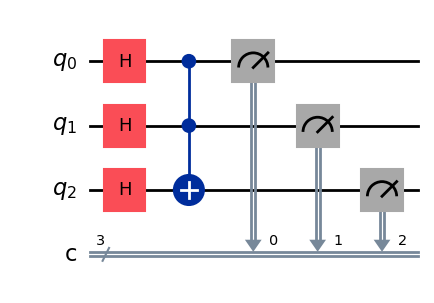


Final Measurement Counts: {'101': 117, '011': 136, '100': 122, '001': 132, '111': 132, '110': 120, '010': 116, '000': 149}


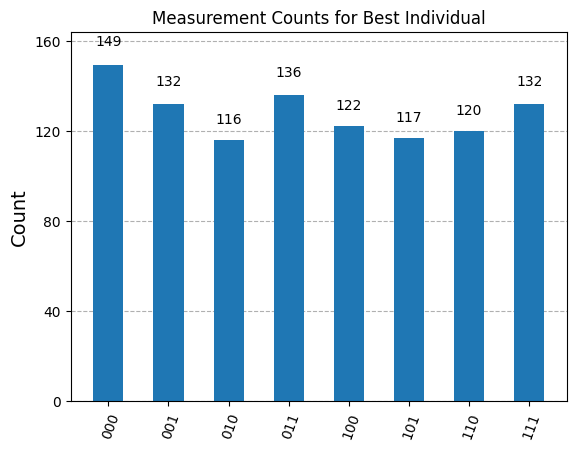

In [17]:
# Inspect the best individual in the Hall of Fame
best_ind = hof.items[0]
print("\nBest Individual's Fitness:", best_ind.fitness.values[0])
print("Genome:", best_ind.genome)
print("Phenotype (code):\n", best_ind.phenotype)

# Decode and display the best circuit
best_circuit = decode_individual(best_ind)
if best_circuit:
    # Display the quantum circuit diagram
    display(best_circuit.draw('mpl'))  # or 'text'

    # Simulate the best circuit using QASM simulator
    simulator = QasmSimulator()
    compiled_circuit = transpile(best_circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1024).result()

    # Get the measurement counts
    counts = result.get_counts()
    corrected_counts = {k[::-1]: v for k, v in counts.items()}  # Reverse bitstrings for readability
    print("\nFinal Measurement Counts:", corrected_counts)

    # Plot the results
    display(plot_histogram(corrected_counts, title="Measurement Counts for Best Individual"))
else:
    print("Best individual could not be decoded into a valid circuit.")

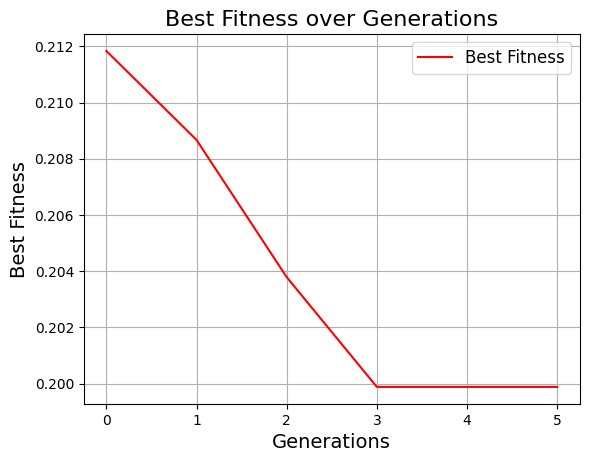

In [18]:
# Extract generations and minimum fitness values
generations = logbook.select("gen")
min_fitness_values = logbook.select("min")

# Plot best fitness over generations
plt.plot(generations, min_fitness_values, color='red', label="Best Fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.grid(True)
plt.show()